<a href="https://colab.research.google.com/github/znah/tpu4fun/blob/master/feature_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inception V1 [feature visualization](https://distill.pub/2017/feature-visualization/) with Google Public Colab TPUs. Rendering 512 feature channels in 8 seconds!

In [1]:
%tensorflow_version 2.x

import os
import numpy as np
from time import time
import tensorflow as tf

import io
import PIL.Image
import base64
from IPython.display import display, Image, HTML, clear_output

TensorFlow 2.x selected.


In [0]:
#@title Image utils

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt='jpeg'):
  if isinstance(f, str):
    f = open(f, 'wb')
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

In [0]:
# Init TPU

tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

In [4]:
# Download pretrained model graph
!gsutil cp gs://modelzoo/vision/other_models/InceptionV1.pb .

Copying gs://modelzoo/vision/other_models/InceptionV1.pb...
- [1 files][ 51.4 MiB/ 51.4 MiB]                                                
Operation completed over 1 objects/51.4 MiB.                                     


In [0]:
data = open('InceptionV1.pb', 'rb').read()
graph_def = tf.compat.v1.GraphDef.FromString(data)
# remove layers starting from 'avgpool0' as they are not input size invariant (and TPU complaints even if we don't eval them)
i = [n.name for n in graph_def.node].index('avgpool0')
del graph_def.node[i:]

In [6]:
layer_name = 'mixed4b'  # The layer to visualize

def _populate_inception_bottlenecks(graph, scope):
  """Add Inception bottlenecks and their pre-Relu versions to the graph."""
  for op in graph.get_operations():
    if op.name.startswith(scope+'/') and 'Concat' in op.type:
      name = op.name.split('/')[1]
      pre_relus = []
      for tower in op.inputs[1:]:
        if tower.op.type == 'Relu':
          tower = tower.op.inputs[0]
        pre_relus.append(tower)
      concat_name = scope + '/' + name + '_pre_relu'
      _ = tf.concat(pre_relus, -1, name=concat_name)

@tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.float32)])
def run_model(inputs):
  image_value_range = (-117.0, 255.0-117.0)
  lo, hi = image_value_range
  prep_inputs = inputs*(hi-lo)+lo
  tf.import_graph_def(graph_def, {'input':prep_inputs})
  g = tf.compat.v1.get_default_graph()
  _populate_inception_bottlenecks(g, 'import')
  t = g.get_tensor_by_name('import/%s_pre_relu:0'%layer_name)
  return t

t = run_model(tf.zeros([1, 128, 128, 3]))
feature_n = t.shape[-1]

print('Layer %s, %d features'%(layer_name, feature_n))

Layer mixed4b, 512 features


In [0]:
# Image parameterizarion (laplacian pyramid)

def create_pyramid(n, h, w, level_n=4, std=0.01):
  sizes = [h, w]//2**np.arange(level_n)[::-1, None]
  return [tf.random.normal([n, h, w, 3])*std for h, w in sizes]

def merge_pyramid(pyr, saturation=0.5):
  img = pyr[0] + [0.5, 0.0, 0.0]
  for hi in pyr[1:]:
    hw = tf.shape(hi)[1:3]
    img = tf.image.resize(img, hw) + hi
  return tf.image.yuv_to_rgb(img*[1.0, saturation, saturation])

In [8]:
@tf.function
def render(ds, iter_n=tf.constant(128), 
           step_size=tf.constant(0.0015),
           saturation=tf.constant(0.6)):
  def tpu_function(d):
    n = tf.shape(d)[0]
    pyr = create_pyramid(n, 128, 128)
    i = 0
    while i < iter_n:
      i += 1
      with tf.GradientTape(persistent=True) as g:
        g.watch(pyr)
        img = merge_pyramid(pyr, saturation)
        shift = tf.random.uniform([2], 0, 32, dtype=tf.int32)
        simg = tf.roll(img, shift, [1, 2])
        t = run_model(simg)
        t = tf.reduce_mean(t, [1, 2])
        score = tf.reduce_sum(t*tf.one_hot(d%feature_n, feature_n))
      grad_img = g.gradient(score, img)
      grad_img /= tf.reduce_mean(tf.abs(grad_img), [1, 2, 3], keepdims=True)+1e-8
      grad_pyr = g.gradient(img, pyr, grad_img)
      pyr = [p+g*step_size for p, g in zip(pyr, grad_pyr)]
    return merge_pyramid(pyr, saturation)
  return strategy.experimental_run_v2(tpu_function, (ds,))

t = time()
pad_feature_n = (feature_n+8-1)//8*8
ds = tf.data.Dataset.range(pad_feature_n).batch(pad_feature_n)
dds = strategy.experimental_distribute_dataset(ds)
batch = iter(dds).next()

res = render(batch)
res = tf.concat(res.values, 0).numpy()
print("Compile + warmup: %.2d s"%(time()-t))

Compile + warmup: 31 s


In [9]:
%%time
res = render(batch)
res = tf.concat(res.values, 0)[:feature_n]
res = tf.pad(res, [(0, 0), (1, 1), (1, 1), (0, 0)]).numpy()

CPU times: user 67 ms, sys: 57.5 ms, total: 125 ms
Wall time: 7.75 s


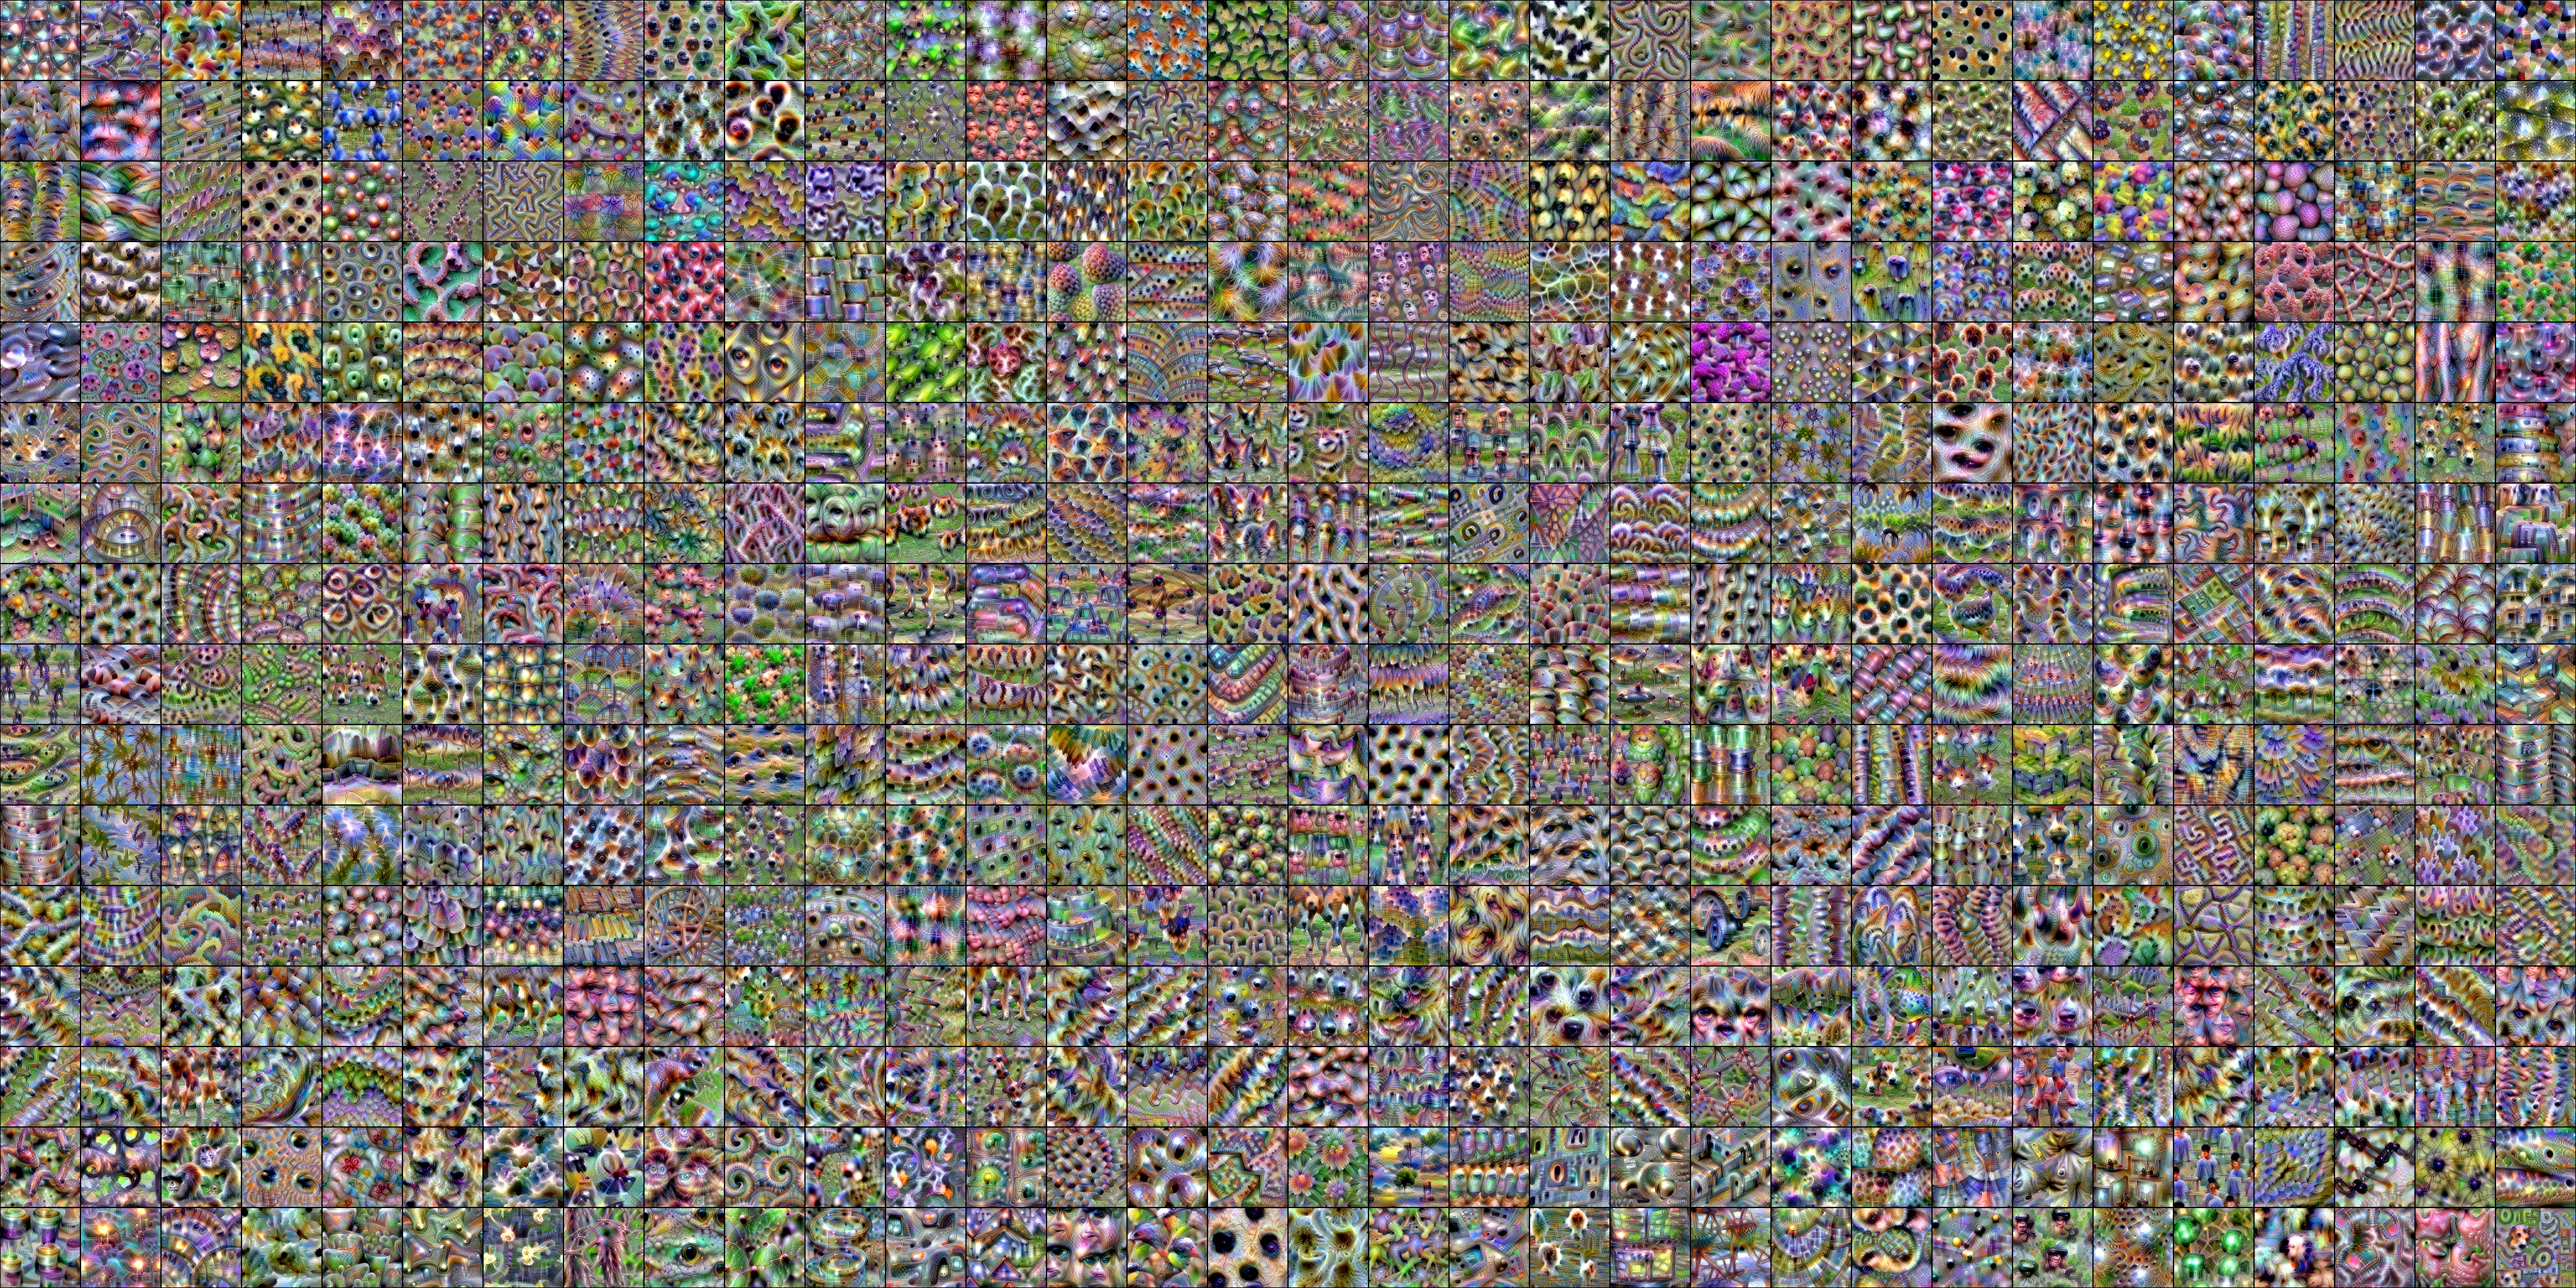

In [10]:
imshow(tile2d(res, 32))